# **BrisT1D Blood Glucose Prediction Competition**

Using historical blood glucose readings, insulin dosage, carbohydrate intake, and smartwatch activity data to predict future blood glucose.



**OBJECTIVE** : Using historical blood glucose readings, insulin dosage, carbohydrate intake, and smartwatch activity data to predict future blood glucose.

Overview

Predicting blood glucose fluctuations is crucial for managing type 1 diabetes. Developing effective algorithms for this can alleviate some of the challenges faced by individuals with the condition.

Goal: Forecast blood glucose levels one hour ahead using the previous six hours of participant data.

**DUE TO THE SIZE WE WILL FIRST EXTRACT OUT THE DATASET THROUGH KAGGLE**

INSTALLING AND IMPORTING KAGGLE

In [ ]:
!pip install kaggle

In [ ]:
#configuring the path of kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#dataset api
!kaggle competitions download -c brist1d

brist1d.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!ls

activities.txt	brist1d.zip  kaggle.json  sample_data  sample_submission.csv  test.csv	train.csv


In [ ]:
#extracting the compressed dataset
from zipfile import ZipFile
#copy the path from the cifar-10 zop data
dataset = '/content/brist1d.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  #for cofirmation of extraction
  print('the dataset is now extracted')

the dataset is now extracted


In [ ]:
!ls

activities.txt	brist1d.zip  kaggle.json  sample_data  sample_submission.csv  test.csv	train.csv


**IMPORTING ALL THE NECESSARY LIBRARIES**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#to keep everything in one plane
%matplotlib inline

In [ ]:
# warnings module in Python provides a way to control how warnings handled within a Python script
import warnings
warnings.filterwarnings('ignore')#ignore the warnings

**LOADING OF THE DATASET**

In [83]:
#Load the training and testing datasets into pandas dataframes.
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

**BASIC DATA INSPECTION**

In [ ]:
print(train_df.head())  # display the first few rows

      id p_num      time  bg-5:55  bg-5:50  bg-5:45  bg-5:40  bg-5:35  \
0  p01_0   p01  06:10:00      NaN      NaN      9.6      NaN      NaN   
1  p01_1   p01  06:25:00      NaN      NaN      9.7      NaN      NaN   
2  p01_2   p01  06:40:00      NaN      NaN      9.2      NaN      NaN   
3  p01_3   p01  06:55:00      NaN      NaN      8.7      NaN      NaN   
4  p01_4   p01  07:10:00      NaN      NaN      8.4      NaN      NaN   

   bg-5:30  bg-5:25  ...  activity-0:40  activity-0:35  activity-0:30  \
0      9.7      NaN  ...            NaN            NaN            NaN   
1      9.2      NaN  ...            NaN            NaN            NaN   
2      8.7      NaN  ...            NaN            NaN            NaN   
3      8.4      NaN  ...            NaN            NaN            NaN   
4      8.1      NaN  ...            NaN            NaN            NaN   

   activity-0:25  activity-0:20  activity-0:15  activity-0:10  activity-0:05  \
0            NaN            NaN           

Understanding the Dataset Columns

1. ID: A unique identifier for each row in the dataset.
2. Participant Number (p_num): A code or ID that identifies the participant who provided the data.
3. Time: The timestamp for each measurement, indicating when the data was collected.
4. Blood Glucose Measurements: The columns labeled bg-5:55, bg-5:50, ..., bg+1:00 represent blood glucose measurements taken at different time points. For example, bg-5:55 represents the blood glucose measurement taken 5 minutes and 55 seconds before the current time.
5. Activity Measurements: The columns labeled activity-0:40, activity-0:35, ..., activity-0:00 represent activity measurements taken at different time points. For example, activity-0:40 represents the activity measurement taken 40 minutes before the current time.

In [ ]:
print(train_df.info())  # display a concise summary of the dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177024 entries, 0 to 177023
Columns: 508 entries, id to bg+1:00
dtypes: float64(433), object(75)
memory usage: 686.1+ MB
None


In [ ]:
# Function to reduce memory usage
def reduce_memory(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print(f"Memory before optimization by train and test: {start_mem:.2f} MB")

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            if str(col_type).startswith("int"):
                df[col] = pd.to_numeric(df[col], downcast="integer")
            elif str(col_type).startswith("float"):
                df[col] = pd.to_numeric(df[col], downcast="float")
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print(f"Memory after optimization by tain and test: {end_mem:.2f} MB")
    print(f"Reduced by {(100 * (start_mem - end_mem) / start_mem):.1f}%")

    return df
# Apply memory reduction
train_df = reduce_memory(train_df)
test_df = reduce_memory(test_df)

Memory before optimization by train and test: 686.10 MB
Memory after optimization by tain and test: 311.18 MB
Reduced by 54.6%
Memory before optimization by train and test: 14.10 MB
Memory after optimization by tain and test: 6.46 MB
Reduced by 54.2%


In [ ]:
train_df.shape

(177024, 508)

In [ ]:
train_df.columns

Index(['id', 'p_num', 'time', 'bg-5:55', 'bg-5:50', 'bg-5:45', 'bg-5:40',
       'bg-5:35', 'bg-5:30', 'bg-5:25',
       ...
       'activity-0:40', 'activity-0:35', 'activity-0:30', 'activity-0:25',
       'activity-0:20', 'activity-0:15', 'activity-0:10', 'activity-0:05',
       'activity-0:00', 'bg+1:00'],
      dtype='object', length=508)

In [ ]:
print(train_df.describe())  # display summary statistics for the dataframe

             bg-5:55        bg-5:50        bg-5:45        bg-5:40  \
count  149770.000000  158533.000000  163364.000000  149766.000000   
mean        8.211019       8.230450       8.253290       8.210987   
std         2.851843       2.913453       2.945681       2.851750   
min         2.200000       2.200000       2.200000       2.200000   
25%         6.100000       6.100000       6.100000       6.100000   
50%         7.600000       7.600000       7.700000       7.600000   
75%         9.800000       9.800000       9.800000       9.800000   
max        22.200001      25.100000      27.799999      22.200001   

             bg-5:35        bg-5:30        bg-5:25        bg-5:20  \
count  158254.000000  163770.000000  149763.000000  157973.000000   
mean        8.229649       8.254084       8.211048       8.228889   
std         2.911026       2.947878       2.851858       2.909040   
min         2.200000       2.200000       2.200000       2.200000   
25%         6.100000       6.1000

In [ ]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [ ]:
train_df.isnull().sum()

,0
id,0
p_num,0
time,0
bg-5:55,27254
bg-5:50,18491
bg-5:45,13660
bg-5:40,27258
bg-5:35,18770
bg-5:30,13254
bg-5:25,27261


Explore the testing data

In [ ]:
#check if there are any rows with all null values:
print(train_df.isnull().all(axis=1).sum())

0


1. Remove columns with a large number of null values (> 50%):
    - activity columns (all)
    - carbs columns (all)
    - insulin columns (all)
2. Impute null values with the mean or median for numerical columns:
    - bg columns (impute with mean)
    - hr columns (impute with mean)
    - steps columns (impute with mean)
    - cals columns (impute with mean)
3. Retain columns with no or few null values:
    - id
    - p_num
    - time
    - bg+1:00

For the activity columns (activity-0:40 to activity-0:00):

- Since these columns have a high number of null values (over 170,000), it's likely that these values are not relevant for the prediction task.
- Remove these columns from the dataset.

For the bg columns (bg-5:55 to bg-5:35):

- Since these columns have a moderate number of null values (over 20,000), it's likely that these values are relevant for the prediction task.
- Impute the null values with the mean of the respective column.


**DATA HANDLING**

In [ ]:
# Remove the activity columns with high null values
activity_cols = [col for col in train_df.columns if 'activity' in col]
train_df.drop(activity_cols, axis=1, inplace=True)

# Impute null values in bg columns with the mean
bg_cols = [col for col in train_df.columns if 'bg' in col]
for col in bg_cols:
    train_df[col].fillna(train_df[col].mean(), inplace=True)

In [ ]:
# Remove columns with a large number of null values (> 50%)
activity_cols = [col for col in train_df.columns if 'activity' in col]
carbs_cols = [col for col in train_df.columns if 'carbs' in col]
insulin_cols = [col for col in train_df.columns if 'insulin' in col]
train_df.drop(activity_cols + carbs_cols + insulin_cols, axis=1, inplace=True)

In [ ]:
# Impute null values with the mean or median for numerical columns
bg_cols = [col for col in train_df.columns if 'bg' in col]
hr_cols = [col for col in train_df.columns if 'hr' in col]
steps_cols = [col for col in train_df.columns if 'steps' in col]
cals_cols = [col for col in train_df.columns if 'cals' in col]
train_df[bg_cols] = train_df[bg_cols].fillna(train_df[bg_cols].mean())
train_df[hr_cols] = train_df[hr_cols].fillna(train_df[hr_cols].mean())
train_df[steps_cols] = train_df[steps_cols].fillna(train_df[steps_cols].mean())
train_df[cals_cols] = train_df[cals_cols].fillna(train_df[cals_cols].mean())

In [ ]:
train_df['p_num'].unique()

['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12']
Categories (9, object): ['p01', 'p02', 'p03', 'p04', ..., 'p06', 'p10', 'p11', 'p12']

In [ ]:
# Define the columns to remove
remove_cols = ['p_num']

# Remove the unwanted columns
train_df.drop(remove_cols, axis=1, inplace=True)

In [ ]:
train_df.shape

(177024, 291)

In [ ]:
train_df.isnull().sum()

,0
id,0
time,0
bg-5:55,0
bg-5:50,0
bg-5:45,0
bg-5:40,0
bg-5:35,0
bg-5:30,0
bg-5:25,0
bg-5:20,0


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_df[bg_cols + hr_cols + steps_cols + cals_cols] = scaler.fit_transform(train_df[bg_cols + hr_cols + steps_cols + cals_cols])

In [ ]:
train_df.dtypes

,0
id,category
time,category
bg-5:55,float32
bg-5:50,float32
bg-5:45,float32
bg-5:40,float32
bg-5:35,float32
bg-5:30,float32
bg-5:25,float32
bg-5:20,float32


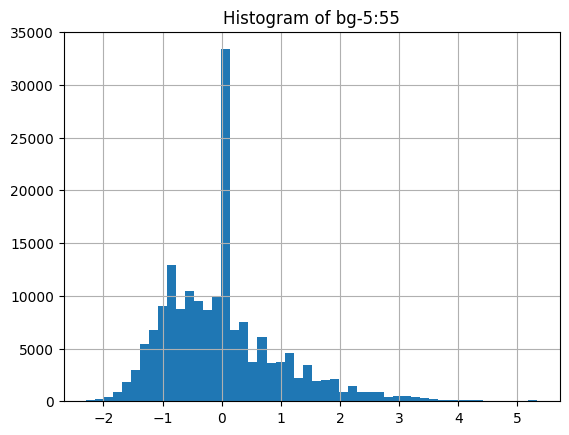

In [ ]:
# Plot a histogram to visualize the data
train_df['bg-5:55'].hist(bins=50)
plt.title('Histogram of bg-5:55')
plt.show()

In [ ]:
# Calculate the z-score for each value in the column
from scipy import stats
z_scores = stats.zscore(train_df['bg-5:55'])

# Print the values with a z-score greater than 3 or less than -3
print(train_df['bg-5:55'][(z_scores > 3) | (z_scores < -3)])

10891     3.159572
10892     3.540749
10893     3.616985
10894     3.312042
10895     3.197690
            ...   
175281    3.045219
175431    3.083336
175432    3.045219
175477    3.045219
175478    3.083336
Name: bg-5:55, Length: 2399, dtype: float32


In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
encoded_data = encoder.fit_transform(train_df[['time']])

In [ ]:
train_df.columns

Index(['id', 'time', 'bg-5:55', 'bg-5:50', 'bg-5:45', 'bg-5:40', 'bg-5:35',
       'bg-5:30', 'bg-5:25', 'bg-5:20',
       ...
       'cals-0:40', 'cals-0:35', 'cals-0:30', 'cals-0:25', 'cals-0:20',
       'cals-0:15', 'cals-0:10', 'cals-0:05', 'cals-0:00', 'bg+1:00'],
      dtype='object', length=291)

**FEATURE ENGINEERING**

In [ ]:
# Convert the 'time' column to datetime format
train_df['time'] = pd.to_datetime(train_df['time'])

# Extract hour, day, and month features
train_df['hour'] = train_df['time'].dt.hour
train_df['day'] = train_df['time'].dt.day
train_df['month'] = train_df['time'].dt.month

In [ ]:
#Average Heart Rate
train_df['avg_hr_30min'] = train_df[['hr-5:55', 'hr-5:50', 'hr-5:45', 'hr-5:40', 'hr-5:35', 'hr-5:30']].mean(axis=1)

In [ ]:
#Total Steps Taken
train_df['total_steps_30min'] = train_df[['steps-5:55', 'steps-5:50', 'steps-5:45', 'steps-5:40', 'steps-5:35', 'steps-5:30']].sum(axis=1)

In [ ]:
#Calories Burned
train_df['total_cals_30min'] = train_df[['cals-5:55', 'cals-5:50', 'cals-5:45', 'cals-5:40', 'cals-5:35', 'cals-5:30']].sum(axis=1)

In [ ]:
#Previous Blood Glucose Levels
train_df['prev_bg_30min'] = train_df[['bg-5:55', 'bg-5:50', 'bg-5:45', 'bg-5:40', 'bg-5:35', 'bg-5:30']].mean(axis=1)

In [ ]:
#Time Since Last Meal
train_df['time'] = train_df['time'].astype(str)
train_df['time_since_last_meal'] = train_df.index.to_series().diff()

In [ ]:
#Time Since Last Insulin Dose
train_df['time'] = pd.to_datetime(train_df['time'], format='%H:%M', errors='coerce')
train_df['time_since_last_insulin'] = (train_df['time'] - train_df['time'].shift(1)).dt.total_seconds()

In [ ]:
#Average Blood Glucose Level
train_df['avg_bg_30min'] = train_df[['bg-5:55', 'bg-5:50', 'bg-5:45', 'bg-5:40', 'bg-5:35', 'bg-5:30']].mean(axis=1)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
print(train_df.columns.tolist())

['id', 'time', 'bg-5:55', 'bg-5:50', 'bg-5:45', 'bg-5:40', 'bg-5:35', 'bg-5:30', 'bg-5:25', 'bg-5:20', 'bg-5:15', 'bg-5:10', 'bg-5:05', 'bg-5:00', 'bg-4:55', 'bg-4:50', 'bg-4:45', 'bg-4:40', 'bg-4:35', 'bg-4:30', 'bg-4:25', 'bg-4:20', 'bg-4:15', 'bg-4:10', 'bg-4:05', 'bg-4:00', 'bg-3:55', 'bg-3:50', 'bg-3:45', 'bg-3:40', 'bg-3:35', 'bg-3:30', 'bg-3:25', 'bg-3:20', 'bg-3:15', 'bg-3:10', 'bg-3:05', 'bg-3:00', 'bg-2:55', 'bg-2:50', 'bg-2:45', 'bg-2:40', 'bg-2:35', 'bg-2:30', 'bg-2:25', 'bg-2:20', 'bg-2:15', 'bg-2:10', 'bg-2:05', 'bg-2:00', 'bg-1:55', 'bg-1:50', 'bg-1:45', 'bg-1:40', 'bg-1:35', 'bg-1:30', 'bg-1:25', 'bg-1:20', 'bg-1:15', 'bg-1:10', 'bg-1:05', 'bg-1:00', 'bg-0:55', 'bg-0:50', 'bg-0:45', 'bg-0:40', 'bg-0:35', 'bg-0:30', 'bg-0:25', 'bg-0:20', 'bg-0:15', 'bg-0:10', 'bg-0:05', 'bg-0:00', 'hr-5:55', 'hr-5:50', 'hr-5:45', 'hr-5:40', 'hr-5:35', 'hr-5:30', 'hr-5:25', 'hr-5:20', 'hr-5:15', 'hr-5:10', 'hr-5:05', 'hr-5:00', 'hr-4:55', 'hr-4:50', 'hr-4:45', 'hr-4:40', 'hr-4:35', 'hr-4:

In [ ]:
print(train_df.columns)

Index(['id', 'time', 'bg-5:55', 'bg-5:50', 'bg-5:45', 'bg-5:40', 'bg-5:35',
       'bg-5:30', 'bg-5:25', 'bg-5:20',
       ...
       'hour', 'day', 'month', 'avg_hr_30min', 'total_steps_30min',
       'total_cals_30min', 'prev_bg_30min', 'time_since_last_meal',
       'time_since_last_insulin', 'avg_bg_30min'],
      dtype='object', length=301)


In [ ]:
from sklearn.model_selection import train_test_split
X = train_df.drop(columns=['bg+1:00'])  # Features, remove the target column
y = train_df['bg+1:00']  # Target column

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 141619 entries, 175765 to 121958
Columns: 300 entries, id to avg_bg_30min
dtypes: category(1), datetime64[ns](1), float32(293), float64(2), int32(3)
memory usage: 170.2 MB
None


In [ ]:
# Drop the 'id' column temporarily for preprocessing and model training
train_df = train_df.drop('id', axis=1)

In [ ]:
# Continue with preprocessing steps
train_df['avg_bg_30min'] = train_df[['bg-5:55', 'bg-5:50', 'bg-5:45', 'bg-5:40', 'bg-5:35', 'bg-5:30']].mean(axis=1)

# Continue with other feature engineering
train_df['avg_hr_30min'] = train_df[['hr-5:55', 'hr-5:50', 'hr-5:45', 'hr-5:40', 'hr-5:35', 'hr-5:30']].mean(axis=1)
train_df['total_steps_30min'] = train_df[['steps-5:55', 'steps-5:50', 'steps-5:45', 'steps-5:40', 'steps-5:35', 'steps-5:30']].sum(axis=1)
train_df['total_cals_30min'] = train_df[['cals-5:55', 'cals-5:50', 'cals-5:45', 'cals-5:40', 'cals-5:35', 'cals-5:30']].sum(axis=1)
train_df['prev_bg_30min'] = train_df[['bg-5:55', 'bg-5:50', 'bg-5:45', 'bg-5:40', 'bg-5:35', 'bg-5:30']].mean(axis=1)

In [ ]:
# Extract relevant time features (hour, day, month)
X_train['hour'] = X_train['time'].dt.hour
X_train['day'] = X_train['time'].dt.day
X_train['month'] = X_train['time'].dt.month

# Drop the original datetime column
X_train.drop('time', axis=1, inplace=True)
X_train= X_train.drop('id', axis=1)

In [ ]:
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 141619 entries, 175765 to 121958
Columns: 298 entries, bg-5:55 to avg_bg_30min
dtypes: float32(293), float64(5)
memory usage: 164.8 MB
None


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Scale the features

In [ ]:
import time
from sklearn.ensemble import RandomForestRegressor

# Start the timer
start_time = time.time()

# Initialize and train the model
model = RandomForestRegressor(n_estimators=20, random_state=42, n_jobs=-1, max_depth=10)
model.fit(X_train_scaled, y_train)

# End the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print(f"Model training took {elapsed_time:.2f} seconds.")

Model training took 275.62 seconds.


In [ ]:
# Ensure that both datasets have the same columns
X_train, X_val = X_train.align(X_val, join='inner', axis=1)

# Scale the data
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [ ]:
# scale both datasets
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [ ]:
X_test = pd.read_csv('test.csv')

In [ ]:
X_train.columns

Index(['bg-5:55', 'bg-5:50', 'bg-5:45', 'bg-5:40', 'bg-5:35', 'bg-5:30',
       'bg-5:25', 'bg-5:20', 'bg-5:15', 'bg-5:10',
       ...
       'hour', 'day', 'month', 'avg_hr_30min', 'total_steps_30min',
       'total_cals_30min', 'prev_bg_30min', 'time_since_last_meal',
       'time_since_last_insulin', 'avg_bg_30min'],
      dtype='object', length=298)

In [ ]:
print(X_test.columns)

Index(['id', 'p_num', 'time', 'bg-5:55', 'bg-5:50', 'bg-5:45', 'bg-5:40',
       'bg-5:35', 'bg-5:30', 'bg-5:25',
       ...
       'activity-0:45', 'activity-0:40', 'activity-0:35', 'activity-0:30',
       'activity-0:25', 'activity-0:20', 'activity-0:15', 'activity-0:10',
       'activity-0:05', 'activity-0:00'],
      dtype='object', length=507)


In [ ]:
X_test['time'] = pd.to_datetime(X_test['time'], errors='coerce')  # Convert to datetime
X_test['time_since_last_meal'] = X_test['time'].diff().dt.total_seconds()
X_test['time_since_last_meal'].fillna(0, inplace=True)  # Fill NaNs with 0

In [ ]:
# Extract time-based features from the 'time' column
X_test['time'] = pd.to_datetime(X_test['time'], errors='coerce')
X_test['hour'] = X_test['time'].dt.hour
X_test['day'] = X_test['time'].dt.day
X_test['month'] = X_test['time'].dt.month
# Ensure 'time' column is in datetime format
X_test['time'] = pd.to_datetime(X_test['time'], format='%H:%M', errors='coerce')
# Compute 'time_since_last_insulin' using the same logic as training
X_test['time_since_last_insulin'] = (X_test['time'] - X_test['time'].shift(1)).dt.total_seconds()
# Handle missing values (fill NaNs with 0 or any other logic you used in training)
X_test['time_since_last_insulin'].fillna(0, inplace=True)
X_test['avg_bg_30min'] = X_test[['bg-5:55', 'bg-5:50', 'bg-5:45', 'bg-5:40', 'bg-5:35', 'bg-5:30']].mean(axis=1)
X_test.drop('time', axis=1, inplace=True)

# Handle categorical columns
for col in X_test.select_dtypes(include=['object', 'category']).columns:
    X_test[col] = X_test[col].astype('category').cat.codes

# Fill missing values with 0
X_test.fillna(0, inplace=True)

In [ ]:
print("Training columns:", list(X_train.columns))
print("Test columns (aligned):", list(X_test_aligned.columns))

Training columns: ['bg-5:55', 'bg-5:50', 'bg-5:45', 'bg-5:40', 'bg-5:35', 'bg-5:30', 'bg-5:25', 'bg-5:20', 'bg-5:15', 'bg-5:10', 'bg-5:05', 'bg-5:00', 'bg-4:55', 'bg-4:50', 'bg-4:45', 'bg-4:40', 'bg-4:35', 'bg-4:30', 'bg-4:25', 'bg-4:20', 'bg-4:15', 'bg-4:10', 'bg-4:05', 'bg-4:00', 'bg-3:55', 'bg-3:50', 'bg-3:45', 'bg-3:40', 'bg-3:35', 'bg-3:30', 'bg-3:25', 'bg-3:20', 'bg-3:15', 'bg-3:10', 'bg-3:05', 'bg-3:00', 'bg-2:55', 'bg-2:50', 'bg-2:45', 'bg-2:40', 'bg-2:35', 'bg-2:30', 'bg-2:25', 'bg-2:20', 'bg-2:15', 'bg-2:10', 'bg-2:05', 'bg-2:00', 'bg-1:55', 'bg-1:50', 'bg-1:45', 'bg-1:40', 'bg-1:35', 'bg-1:30', 'bg-1:25', 'bg-1:20', 'bg-1:15', 'bg-1:10', 'bg-1:05', 'bg-1:00', 'bg-0:55', 'bg-0:50', 'bg-0:45', 'bg-0:40', 'bg-0:35', 'bg-0:30', 'bg-0:25', 'bg-0:20', 'bg-0:15', 'bg-0:10', 'bg-0:05', 'bg-0:00', 'hr-5:55', 'hr-5:50', 'hr-5:45', 'hr-5:40', 'hr-5:35', 'hr-5:30', 'hr-5:25', 'hr-5:20', 'hr-5:15', 'hr-5:10', 'hr-5:05', 'hr-5:00', 'hr-4:55', 'hr-4:50', 'hr-4:45', 'hr-4:40', 'hr-4:35', 'h

In [69]:
training_columns =['bg-5:55', 'bg-5:50', 'bg-5:45', 'bg-5:40', 'bg-5:35', 'bg-5:30', 'bg-5:25', 'bg-5:20', 'bg-5:15', 'bg-5:10', 'bg-5:05', 'bg-5:00', 'bg-4:55', 'bg-4:50', 'bg-4:45', 'bg-4:40', 'bg-4:35', 'bg-4:30', 'bg-4:25', 'bg-4:20', 'bg-4:15', 'bg-4:10', 'bg-4:05', 'bg-4:00', 'bg-3:55', 'bg-3:50', 'bg-3:45', 'bg-3:40', 'bg-3:35', 'bg-3:30', 'bg-3:25', 'bg-3:20', 'bg-3:15', 'bg-3:10', 'bg-3:05', 'bg-3:00', 'bg-2:55', 'bg-2:50', 'bg-2:45', 'bg-2:40', 'bg-2:35', 'bg-2:30', 'bg-2:25', 'bg-2:20', 'bg-2:15', 'bg-2:10', 'bg-2:05', 'bg-2:00', 'bg-1:55', 'bg-1:50', 'bg-1:45', 'bg-1:40', 'bg-1:35', 'bg-1:30', 'bg-1:25', 'bg-1:20', 'bg-1:15', 'bg-1:10', 'bg-1:05', 'bg-1:00', 'bg-0:55', 'bg-0:50', 'bg-0:45', 'bg-0:40', 'bg-0:35', 'bg-0:30', 'bg-0:25', 'bg-0:20', 'bg-0:15', 'bg-0:10', 'bg-0:05', 'bg-0:00', 'hr-5:55', 'hr-5:50', 'hr-5:45', 'hr-5:40', 'hr-5:35', 'hr-5:30', 'hr-5:25', 'hr-5:20', 'hr-5:15', 'hr-5:10', 'hr-5:05', 'hr-5:00', 'hr-4:55', 'hr-4:50', 'hr-4:45', 'hr-4:40', 'hr-4:35', 'hr-4:30', 'hr-4:25', 'hr-4:20', 'hr-4:15', 'hr-4:10', 'hr-4:05', 'hr-4:00', 'hr-3:55', 'hr-3:50', 'hr-3:45', 'hr-3:40', 'hr-3:35', 'hr-3:30', 'hr-3:25', 'hr-3:20', 'hr-3:15', 'hr-3:10', 'hr-3:05', 'hr-3:00', 'hr-2:55', 'hr-2:50', 'hr-2:45', 'hr-2:40', 'hr-2:35', 'hr-2:30', 'hr-2:25', 'hr-2:20', 'hr-2:15', 'hr-2:10', 'hr-2:05', 'hr-2:00', 'hr-1:55', 'hr-1:50', 'hr-1:45', 'hr-1:40', 'hr-1:35', 'hr-1:30', 'hr-1:25', 'hr-1:20', 'hr-1:15', 'hr-1:10', 'hr-1:05', 'hr-1:00', 'hr-0:55', 'hr-0:50', 'hr-0:45', 'hr-0:40', 'hr-0:35', 'hr-0:30', 'hr-0:25', 'hr-0:20', 'hr-0:15', 'hr-0:10', 'hr-0:05', 'hr-0:00', 'steps-5:55', 'steps-5:50', 'steps-5:45', 'steps-5:40', 'steps-5:35', 'steps-5:30', 'steps-5:25', 'steps-5:20', 'steps-5:15', 'steps-5:10', 'steps-5:05', 'steps-5:00', 'steps-4:55', 'steps-4:50', 'steps-4:45', 'steps-4:40', 'steps-4:35', 'steps-4:30', 'steps-4:25', 'steps-4:20', 'steps-4:15', 'steps-4:10', 'steps-4:05', 'steps-4:00', 'steps-3:55', 'steps-3:50', 'steps-3:45', 'steps-3:40', 'steps-3:35', 'steps-3:30', 'steps-3:25', 'steps-3:20', 'steps-3:15', 'steps-3:10', 'steps-3:05', 'steps-3:00', 'steps-2:55', 'steps-2:50', 'steps-2:45', 'steps-2:40', 'steps-2:35', 'steps-2:30', 'steps-2:25', 'steps-2:20', 'steps-2:15', 'steps-2:10', 'steps-2:05', 'steps-2:00', 'steps-1:55', 'steps-1:50', 'steps-1:45', 'steps-1:40', 'steps-1:35', 'steps-1:30', 'steps-1:25', 'steps-1:20', 'steps-1:15', 'steps-1:10', 'steps-1:05', 'steps-1:00', 'steps-0:55', 'steps-0:50', 'steps-0:45', 'steps-0:40', 'steps-0:35', 'steps-0:30', 'steps-0:25', 'steps-0:20', 'steps-0:15', 'steps-0:10', 'steps-0:05', 'steps-0:00', 'cals-5:55', 'cals-5:50', 'cals-5:45', 'cals-5:40', 'cals-5:35', 'cals-5:30', 'cals-5:25', 'cals-5:20', 'cals-5:15', 'cals-5:10', 'cals-5:05', 'cals-5:00', 'cals-4:55', 'cals-4:50', 'cals-4:45', 'cals-4:40', 'cals-4:35', 'cals-4:30', 'cals-4:25', 'cals-4:20', 'cals-4:15', 'cals-4:10', 'cals-4:05', 'cals-4:00', 'cals-3:55', 'cals-3:50', 'cals-3:45', 'cals-3:40', 'cals-3:35', 'cals-3:30', 'cals-3:25', 'cals-3:20', 'cals-3:15', 'cals-3:10', 'cals-3:05', 'cals-3:00', 'cals-2:55', 'cals-2:50', 'cals-2:45', 'cals-2:40', 'cals-2:35', 'cals-2:30', 'cals-2:25', 'cals-2:20', 'cals-2:15', 'cals-2:10', 'cals-2:05', 'cals-2:00', 'cals-1:55', 'cals-1:50', 'cals-1:45', 'cals-1:40', 'cals-1:35', 'cals-1:30', 'cals-1:25', 'cals-1:20', 'cals-1:15', 'cals-1:10', 'cals-1:05', 'cals-1:00', 'cals-0:55', 'cals-0:50', 'cals-0:45', 'cals-0:40', 'cals-0:35', 'cals-0:30', 'cals-0:25', 'cals-0:20', 'cals-0:15', 'cals-0:10', 'cals-0:05', 'cals-0:00', 'hour', 'day', 'month', 'avg_hr_30min', 'total_steps_30min', 'total_cals_30min', 'prev_bg_30min', 'time_since_last_meal', 'time_since_last_insulin', 'avg_bg_30min']

In [64]:
X_test_aligned = X_test[train_columns]  # Use the columns from the training data

In [66]:
print("Missing in X_test_aligned:", X_train.columns.difference(X_test_aligned.columns))
print("Extra in X_test_aligned:", X_test_aligned.columns.difference(X_train.columns))

Missing in X_test_aligned: Index([], dtype='object')
Extra in X_test_aligned: Index([], dtype='object')


In [70]:
# Align the order of columns in test data with training data
X_test_aligned = X_test[training_columns]  # Ensure 'training_columns' is a list of column names in order from the training set

In [71]:
# Check if the column order matches
if list(X_train.columns) != list(X_test_aligned.columns):
    print("Feature order mismatch!")
    print("Training feature order:", list(X_train.columns))
    print("Test feature order:", list(X_test_aligned.columns))
    X_test_aligned = X_test_aligned[X_train.columns]

In [73]:
# Recreate derived features from training preprocessing
X_test['avg_hr_30min'] = X_test[['hr-5:55', 'hr-5:50', 'hr-5:45', 'hr-5:40', 'hr-5:35', 'hr-5:30']].mean(axis=1)
X_test['total_steps_30min'] = X_test[['steps-5:55', 'steps-5:50', 'steps-5:45', 'steps-5:40', 'steps-5:35', 'steps-5:30']].sum(axis=1)
X_test['total_cals_30min'] = X_test[['cals-5:55', 'cals-5:50', 'cals-5:45', 'cals-5:40', 'cals-5:35', 'cals-5:30']].sum(axis=1)
X_test['prev_bg_30min'] = X_test[['bg-5:55', 'bg-5:50', 'bg-5:45', 'bg-5:40', 'bg-5:35', 'bg-5:30']].mean(axis=1)

In [74]:
# Reorder X_test_aligned columns to match the scaler's order
X_test_aligned = X_test_aligned[X_train.columns]

In [75]:
# Check if there are missing or extra columns in X_test_aligned
missing_features = set(X_train.columns) - set(X_test_aligned.columns)
extra_features = set(X_test_aligned.columns) - set(X_train.columns)

print("Missing features:", missing_features)
print("Extra features:", extra_features)

for feature in missing_features:
    X_test_aligned[feature] = 0  # or some default value
X_test_aligned = X_test_aligned[X_train.columns]

Missing features: set()
Extra features: set()


In [76]:
X_test_scaled = scaler.transform(X_test_aligned)

In [77]:
y_pred = model.predict(X_test_scaled)

In [81]:
df = pd.read_csv('/content/test.csv')

In [82]:
# Prepare the submission file using the 'id' column from X_test
submission = pd.DataFrame({
    'id': df['id'],
    'bg+1:00': y_pred  # model predictions for the test set
})

# Save the submission file
submission.to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' created successfully.")

Submission file 'submission.csv' created successfully.
